In [3]:
import os
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt


In [4]:
input_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2023-09-19-wendyw-WW_SC_005/documents/Nectow Lab Maf Files/'
maf_files = sorted(os.listdir(input_path))

In [5]:
def generate_stitching_order(maf_file_path, output_path):
    
    df = pd.read_xml(maf_file_path)
    df = df.loc[:, ["StageXPos", "StageYPos", "PositionID"]]
    
    # get the steps 
    temp = df['StageYPos'].shift(-1) - df['StageYPos']
    step = pd.value_counts(temp).index.values[0]
    
    # get the relative positions
    point_relative_min = [df.loc[:,'StageXPos'].min(), df.loc[:,'StageYPos'].min()]
    point_relative_max = [df.loc[:,'StageXPos'].max(), df.loc[:,'StageYPos'].max()]
    coo_shape = np.array(point_relative_max) - np.array(point_relative_min)
    coo_shape = (coo_shape / step + 0.5 + 1).astype(int)
    df['relative_x'] = np.array((df['StageXPos'] - point_relative_min[0])/step + 0.5, dtype=int)
    df['relative_y'] = np.array((df['StageYPos'] - point_relative_min[1])/step + 0.5, dtype=int)
    df = df.loc[:, ['PositionID', 'relative_x', 'relative_y']]
    
    # construct coo matrix
    value = df.loc[:,'PositionID'].values
    row = df.loc[:,'relative_y'].values
    col = df.loc[:,'relative_x'].values
    matrix_shape = [coo_shape[1], coo_shape[0]]

    ordering_matrix = coo_matrix((value, (row,col)), shape=matrix_shape).toarray()

    ordering_matrix = np.rot90(ordering_matrix)
    ordering_matrix = np.flip(ordering_matrix, axis=1)
    
    ordering_df = pd.DataFrame(ordering_matrix)
    ordering_list = ordering_df.unstack(1)
    output_df = pd.DataFrame(ordering_list)
    output_df = output_df.reset_index()
    output_df.columns = ["col", "row", "id"]
    output_df['grid'] = "tile_" + output_df['row'].astype(str) + output_df['col'].astype(str)

    fig, ax = plt.subplots()
    plt.imshow(ordering_matrix > 0)
    plt.xticks(np.arange(-0.5, max(col)+0.5, 1.0))
    plt.yticks(np.arange(-0.5, max(row)+0.5, 1.0))
    plt.grid()
    
    for i in range(output_df.shape[0]):
        plt.text(output_df.iloc[i, 0]-0.1, output_df.iloc[i, 1]-0.1, output_df.iloc[i, 2], color='blue', size=5)
        plt.text(output_df.iloc[i, 0]-0.25, output_df.iloc[i, 1]+0.1, output_df.iloc[i, 3], color='blue', size=5)

    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)

    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    plt.savefig(os.path.join(output_path))
    plt.show()

    return output_df

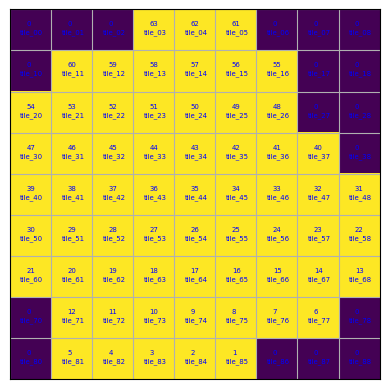

,col,row,id,grid
0,0,0,0,tile_00
1,0,1,0,tile_10
2,0,2,54,tile_20
3,0,3,47,tile_30
4,0,4,39,tile_40
...,...,...,...,...
76,8,4,31,tile_48
77,8,5,22,tile_58
78,8,6,13,tile_68
79,8,7,0,tile_78


In [6]:
test_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2023-09-19-wendyw-WW_SC_005/images/stitching/Sample1/grid.tif'

df = generate_stitching_order(os.path.join(input_path, maf_files[0]), test_path)
df

In [7]:
from tifffile import imwrite

x, y = [2048, 2048]
output_dir = '/home/unix/jiahao/wanglab/Data/Analyzed/2023-09-19-wendyw-WW_SC_005/images/stitching'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    

# Create blank tile
blank_2d = np.zeros((x, y), dtype=np.uint8)

# Save blank tile to output directory
imwrite(os.path.join(output_dir, 'blank.tif'), blank_2d)

  0%|          | 0/8 [00:00<?, ?it/s]

Sample1


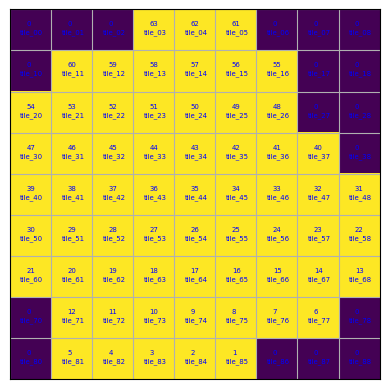

  0%|          | 0/81 [00:00<?, ?it/s]

Sample2


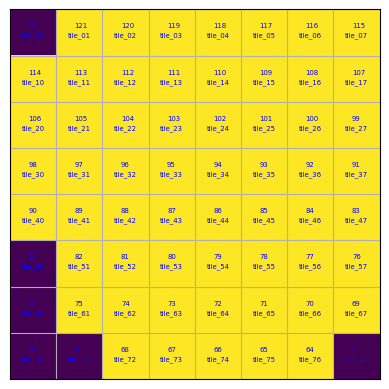

  0%|          | 0/64 [00:00<?, ?it/s]

Sample3


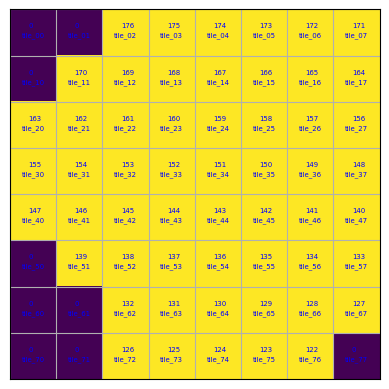

  0%|          | 0/64 [00:00<?, ?it/s]

Sample4


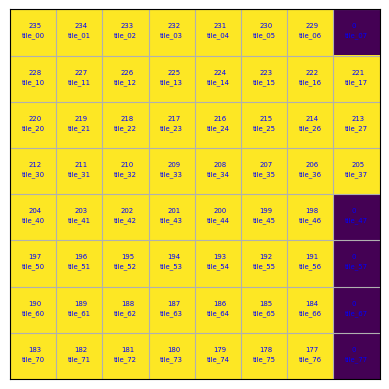

  0%|          | 0/64 [00:00<?, ?it/s]

Sample5


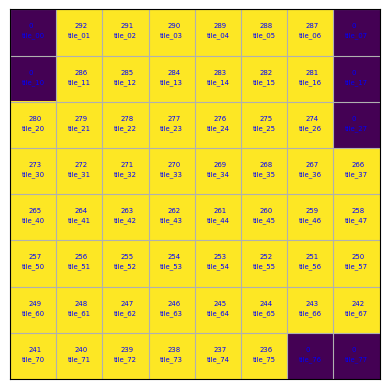

  0%|          | 0/64 [00:00<?, ?it/s]

Sample6


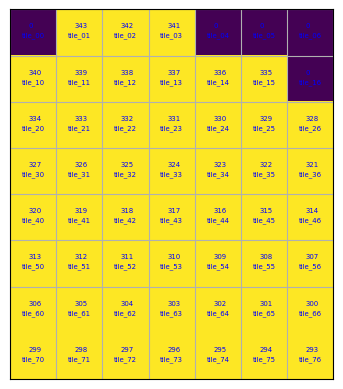

  0%|          | 0/56 [00:00<?, ?it/s]

Sample7


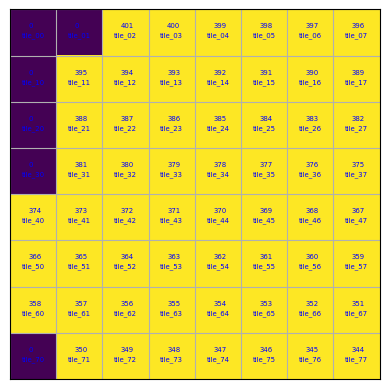

  0%|          | 0/64 [00:00<?, ?it/s]

Sample8


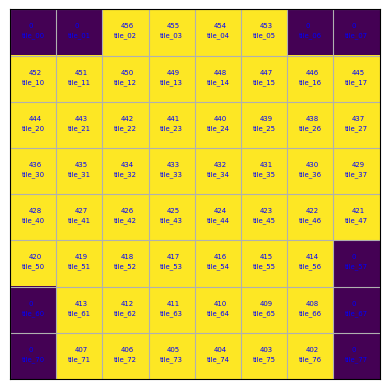

  0%|          | 0/64 [00:00<?, ?it/s]

In [8]:
from tqdm.notebook import tqdm
import shutil

base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2023-09-19-wendyw-WW_SC_005/'
samples = [f.split("_")[-1].split(".")[0] for f in maf_files]

for i, current_sample in enumerate(tqdm(samples)):
    print(current_sample)
    current_output_path = os.path.join(base_path, f'images/stitching/{current_sample}')
    if not os.path.exists(current_output_path):
        os.mkdir(current_output_path)

    current_grid_fname = os.path.join(current_output_path, 'grid.tif')
    current_df = generate_stitching_order(os.path.join(input_path, maf_files[i]), current_grid_fname)
    current_df.to_csv(os.path.join(current_output_path, 'grid.csv'))

    input_ref_merged_path = os.path.join(base_path, 'images/ref_merged')
    input_dapi_merged_path = os.path.join(base_path, 'images/DAPI')

    current_ref_merged_output_path = os.path.join(current_output_path, 'ref_merged')
    if not os.path.exists(current_ref_merged_output_path):
        os.mkdir(current_ref_merged_output_path)

    current_DAPI_output_path = os.path.join(current_output_path, 'DAPI')
    if not os.path.exists(current_DAPI_output_path):
        os.mkdir(current_DAPI_output_path)
        
    for j in tqdm(range(0, current_df.shape[0])):
        current_id = current_df.iloc[j, 2]
        current_grid = current_df.iloc[j, 3]
        current_position_id = f"Position{current_id:03}"

        # print(current_position_id, current_grid)
        if current_id == 0:
            src = os.path.join(base_path, 'images/stitching', 'blank.tif')
            dest_merged = os.path.join(current_ref_merged_output_path, f"{current_grid}.tif")
            dest_dapi = os.path.join(current_DAPI_output_path, f"{current_grid}.tif")
            
            shutil.copyfile(src, dest_merged)
            shutil.copyfile(src, dest_dapi)

            # os.symlink(src, dest_merged)
            # os.symlink(src, dest_dapi)
        else:
            src_merged = os.path.join(input_ref_merged_path, f"{current_position_id}.tif")
            src_dapi = os.path.join(input_dapi_merged_path, f"{current_position_id}.tif")
            
            dest_merged = os.path.join(current_ref_merged_output_path, f"{current_grid}.tif")
            dest_dapi = os.path.join(current_DAPI_output_path, f"{current_grid}.tif")

            shutil.copyfile(src_merged, dest_merged)
            shutil.copyfile(src_dapi, dest_dapi)

            # os.symlink(src_merged, dest_merged)
            # os.symlink(src_dapi, dest_dapi)